In [1]:
# This script requires you to use a DESI kernel

%matplotlib inline
# matplotlib widget doesn't seem to work
# %matplotlib widget
import sys
import math
import logging
import random
import numpy as np
import psycopg2
import psycopg2.extras
from matplotlib import pyplot

from mosthosts_desi import MostHostsDesi
from desi_specinfo import TargetNotFound, SpectrumInfo

logger = logging.getLogger("main")
ch = logging.StreamHandler(sys.stderr)
logger.addHandler(ch)
formatter = logging.Formatter(
    f"[%(asctime)s - %(levelname)s] - %(message)s"
)
ch.setFormatter(formatter)
logger.setLevel( logging.INFO )

In [2]:
# Replace these next two lines with something that sets dbpasswd to the
#  right value.  It can be as simple as
#    dbpasswd = '...'
#  with the right thing in place of ...
with open("/global/homes/r/raknop/secrets/decatdb_desi_desi") as ifp:
    (dbuser,dbpasswd) = ifp.readline().strip().split()
    
# Read in the MostHosts data with info on what's been observed by desi
mosthosts = MostHostsDesi()

[2021-11-30 13:53:41,820 - INFO] - Reading mosthosts_desi.csv
[2021-11-30 13:53:44,398 - INFO] - Checking...
[2021-11-30 13:53:44,457 - INFO] - Read mosthosts_desi.csv


In [3]:
# Which SN do we want to look at?  Make it None to choose a random one.
# This name has to match the name used in SkyPortal (TNS name first,
# then IAU name if TNS doesn't exist, then PTFIPTF if IAU doesn't
# exist, then whatever's in the snname field.  This is what is in
# the "spname" index of mosthosts.haszdf.)
# sntoshow = '13ut'
sntoshow = None

if sntoshow is None:
    sne = mosthosts.haszdf.index.unique( level=0 )
    dex = random.randint(0, len(sne)-1)
    spname = sne[dex]
else:
    spname = sntoshow

logger.info( f'Going to look at spectra for {spname}' )


[2021-11-30 13:53:45,436 - INFO] - Going to look at spectra for iPTF13ta


In [4]:
sub = mosthosts.haszdf.loc[ spname, : ]
logger.info( f'There are {len(sub)} hosts with 1 or more desi spectra.' )

allhostdata = []

for index, ra, dec in zip( sub.index, sub['ra'], sub['dec'] ):
    try:
        index = int(index)
        specinfo = SpectrumInfo( ra, dec, desipasswd=dbpasswd, logger=logger)
        allhostdata.append( specinfo )
        print( f'Host {index} of {spname} at {ra:.4f}, {dec:.4f} has {len(specinfo.targetids)} spectra' )
        for targetid in specinfo.targetids:
            targetinfo = specinfo.info_for_targetid( targetid )
            for info in targetinfo:
                print( f'  targetid={targetid}, tileid={info["tileid"]}, petal_loc={info["petal_loc"]}, '
                       f'device_loc={info["device_loc"]}, night={info["night"]}, z={info["z"]:.3f}±{info["zerr"]:.3f}',
                       f'zwarn={info["zwarn"]}' )
                print( f'   filename={info["filename"]}' )
    except TargetNotFound as ex:
        logger.error( f'No spectra found for host {index} of {mosthost_name} at ({ra:.4f}, {dec:.4f})' )
        continue

[2021-11-30 13:53:46,836 - INFO] - There are 1 hosts with 1 or more desi spectra.
[2021-11-30 13:53:46,855 - INFO] - Looking for daily spectra at (210.6826, 5.7349)
[2021-11-30 13:53:46,890 - INFO] - Done looking for daily spectra at (210.6826, 5.7349)


Host 2 of iPTF13ta at 210.6826, 5.7349 has 1 spectra
  targetid=39627927029024011, tileid=148, petal_loc=6, device_loc=254, night=20210407, z=0.063±0.000 zwarn=0
   filename=/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/148/20210407/coadd-6-148-thru20210407.fits


INFO:spectra.py:282:read_spectra: iotime 0.756 sec to read coadd-6-148-thru20210407.fits at 2021-11-30T13:53:49.173128


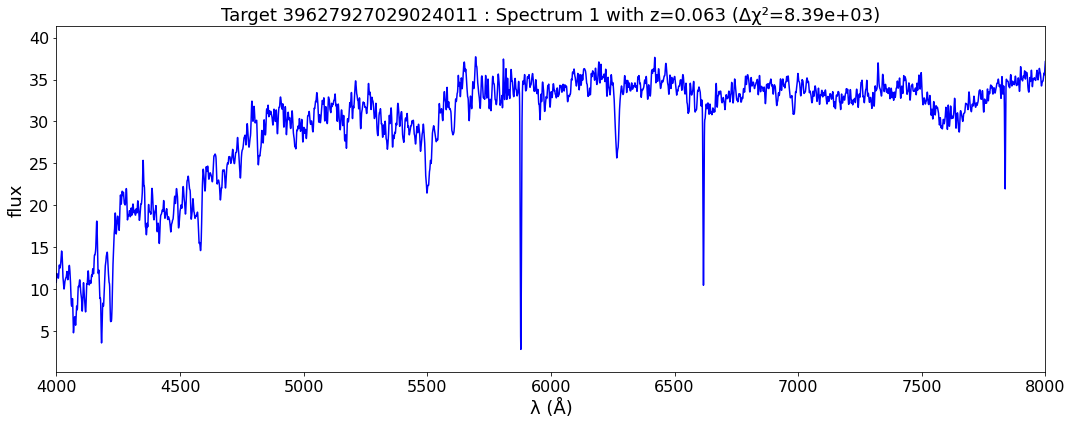

In [5]:
# Plot limits.  Make them None to autoscale
fmin = None
fmax = None
λmin = 4000
λmax = 8000
gausssmooth = 2

targnum = -1
for hostcollection in allhostdata:
    for targetid in hostcollection.targetids:
        targnum += 1
        infos = hostcollection.info_for_targetid( targetid )
        spectra = hostcollection.get_spectra( targetid, smooth=gausssmooth )
        specnum = 0
        for info, spec in zip( infos, spectra):
            specnum += 1
            fig = pyplot.figure( figsize=(15,6), tight_layout=True )
            ax = fig.add_subplot( 1, 1, 1 )
            title = ( f'Target {targetid} : Spectrum {specnum} '
                      # f'Tile {spec["tileid"]} on night {spec["night"]} '
                      f'with z={info["z"]:.3f}' )
            if info["zwarn"] != 0:
                title += f' (zwarn={info["zwarn"]})'
            title += f' (Δχ²={info["deltachi2"]:.3g})'
            ax.set_title( title, fontsize=18 )
            ax.set_xlabel( 'λ (Å)', fontsize=18 )
            ax.set_ylabel( 'flux', fontsize=18 )
            ax.tick_params( axis='both', labelsize=16 )
            if λmin is not None:
                ax.set_xlim( λmin, λmax )
            if fmin is not None:
                ax.set_ylim( fmin, fmax )
            λ = spec.wave['brz']
            flux = spec.flux['brz'][0, :]
            ax.plot( λ, flux, 'b' )
            fig.show()
